# Business problem we are trying to solve

# 0. Import the necessary libraries

In [252]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from pathlib import Path
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib
%matplotlib inline

# 1. Get the data

## 1.1 Import csv file

In [150]:
train_original = pd.read_csv('datasets/train.csv')
test_original = pd.read_csv('datasets/test.csv')

## 1.2 Split the data into training and test sets

In [151]:
train_original.shape

(30000, 24)

In [152]:
test_original.shape

(20000, 23)

In [153]:
train_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [154]:
test_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

In [155]:
pd.set_option('display.max_columns', None)
train_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [156]:
test_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3
2,C-34590,Keva Godfrey,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.1
4,C-12196,Sade Constable,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.0


Since the test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and test dataset.

In [157]:
full_data = train_original

In [158]:
full_data.shape

(30000, 24)

In [159]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [160]:
loan_amt_train_original, loan_amt_test_original = data_split(full_data, 0.2)

In [161]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train_original.copy(), loan_amt_test_original.copy()

In [162]:
loan_amt_train_copy.shape

(24000, 24)

In [163]:
loan_amt_test_copy.shape

(6000, 24)

# 2. Explore the data

## 2.1 Quick glance at the data

In [164]:
loan_amt_train_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-15808,Minerva Dundon,M,27,12398.65,Low,Working,Managers,Urban,294604.89,1255.89,Y,N,2.0,NaN,0,Active,540,12398.65,4,Semi-Urban,1,526542.91,235683.91
1,C-29367,Darius Granado,M,36,NaN,Low,Working,NaN,Semi-Urban,132263.08,500.43,N,N,1.0,646.05,1,NaN,320,NaN,3,Urban,1,250293.24,0.00
2,C-20386,Verlene Hagar,M,52,NaN,Low,Commercial associate,Sales staff,Semi-Urban,112307.54,539.09,N,Y,1.0,706.42,0,Active,6,NaN,2,Rural,1,157866.23,72999.90
3,C-14237,Yang Leitner,F,18,NaN,Low,Working,Laborers,Rural,24268.35,168.21,N,N,2.0,640.23,0,Unpossessed,869,NaN,2,Urban,1,30470.51,0.00
4,C-14759,Ilda Jeffords,F,18,2203.52,Low,Working,Laborers,Semi-Urban,76342.04,681.95,N,Y,2.0,835.55,0,Inactive,21,2203.52,3,Urban,1,142224.12,57256.53


In [165]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

In [166]:
loan_amt_train_copy.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,24000.000000,20352.000000,24000.000000,23872.000000,21983.000000,22623.000000,24000.000000,24000.000000,20149.000000,24000.000000,24000.000000,2.400000e+04,23725.000000
mean,40.058417,2567.533530,89075.615086,401.409325,2.250512,739.726632,0.193875,502.302000,2567.841029,2.463708,-4.686333,1.320183e+05,47680.600489
std,16.029209,1775.075442,59637.687461,241.893479,0.947379,72.271823,0.395340,288.707474,1776.812939,1.121005,74.227397,9.356624e+04,48224.124688
min,18.000000,378.760000,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,378.760000,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1652.707500,41272.637500,248.932500,2.000000,681.225000,0.000000,251.000000,1653.040000,1.000000,1.000000,6.079394e+04,0.000000
50%,40.000000,2229.965000,75326.655000,375.275000,2.000000,739.880000,0.000000,503.000000,2231.100000,2.000000,1.000000,1.101687e+05,35273.020000
75%,55.000000,3092.775000,120378.247500,521.215000,3.000000,799.090000,0.000000,753.000000,3094.050000,3.000000,1.000000,1.790840e+05,74217.940000
max,65.000000,122966.280000,621497.820000,3419.660000,10.000000,896.260000,1.000000,999.000000,122966.280000,4.000000,1.000000,1.077967e+06,395368.740000


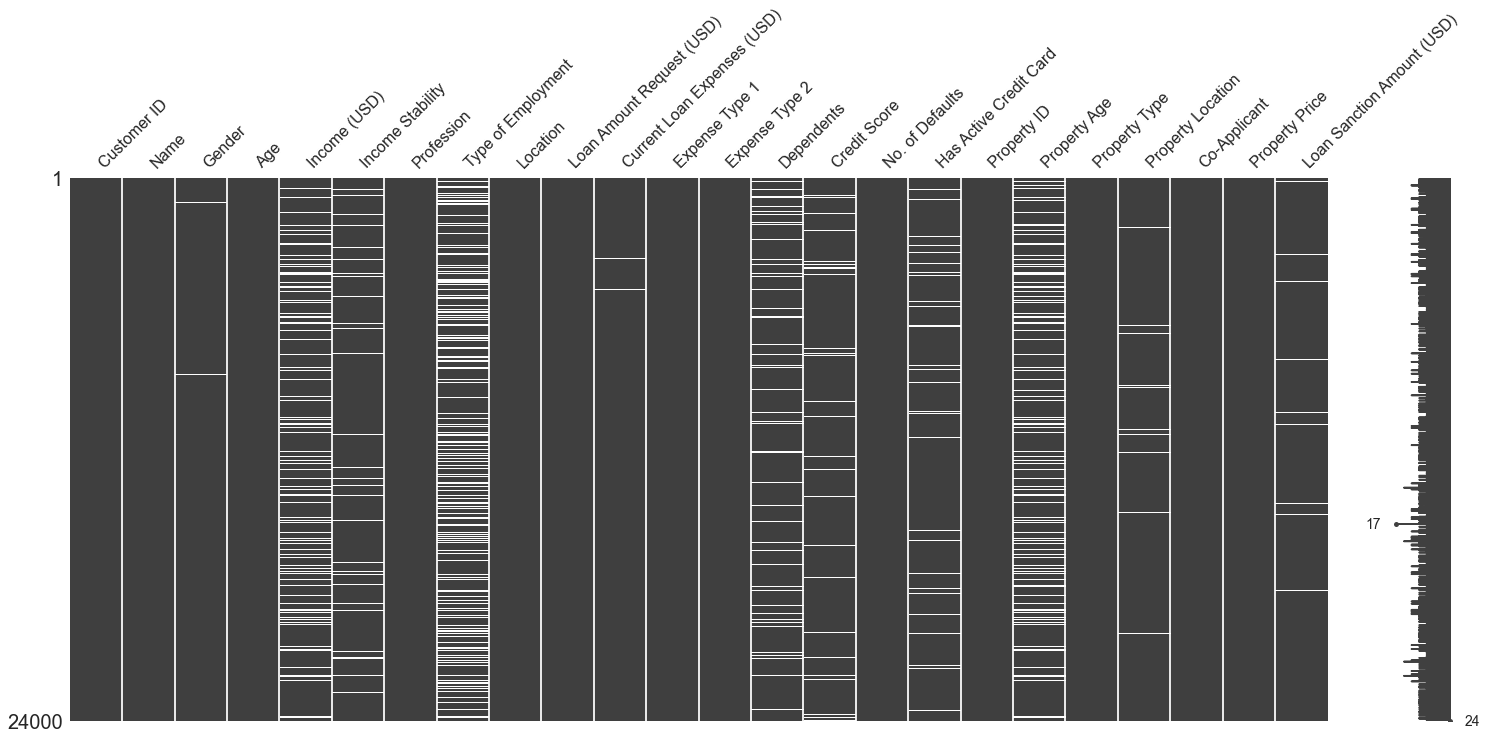

In [167]:
msno.matrix(loan_amt_train_copy)
plt.show()

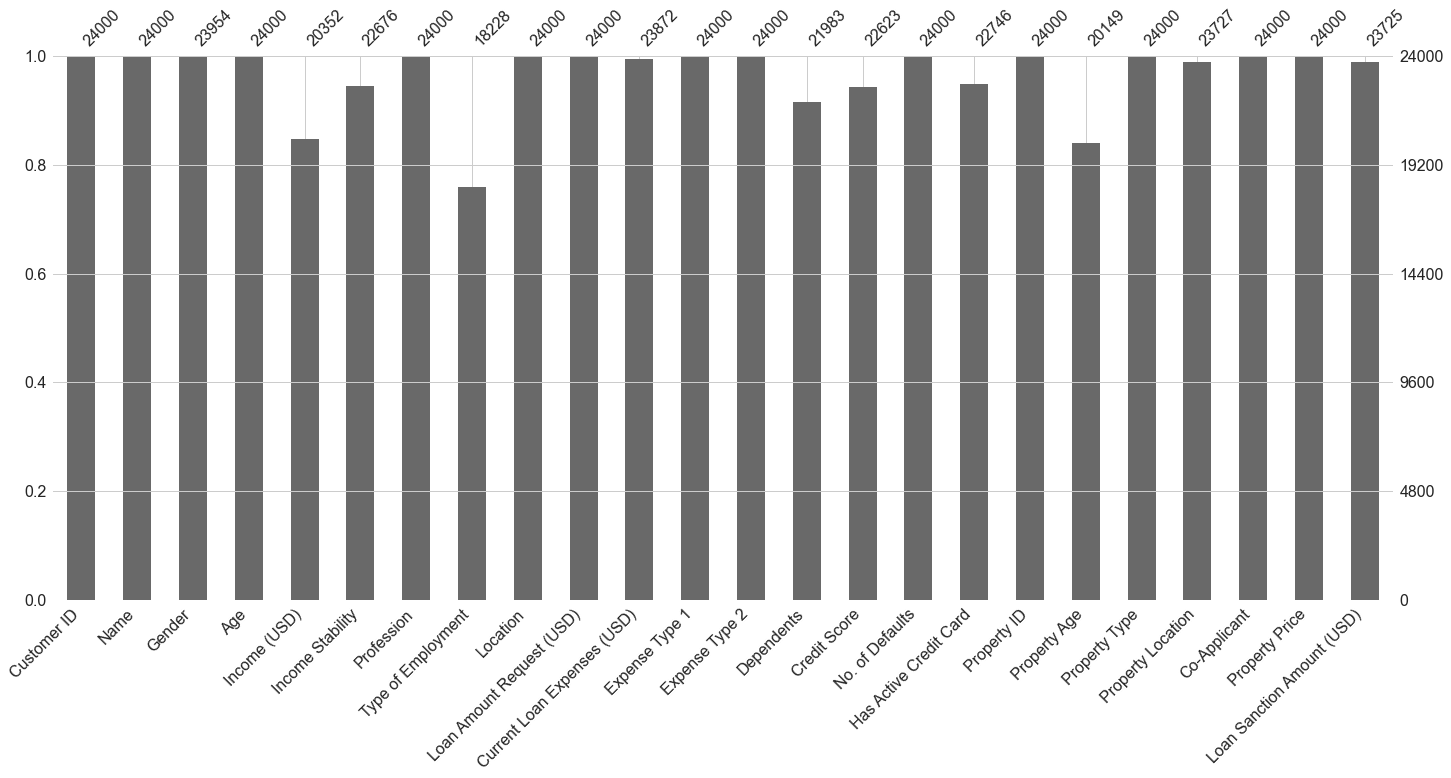

In [168]:
msno.bar(loan_amt_train_copy)
plt.show()

## 2.2 Functions used in the EDA of each feature

In [169]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [273]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)' | 'Loan Amount Request (USD)' | 'Current Loan Expenses (USD)' | 'Credit Score' | 'Property Age':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
        case ''
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [246]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    match feature:
        case 'Profession' | 'Type of Employment' | 'Dependents':
            fig, ax = plt.subplots(figsize=(8,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0], color='dimgray')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()

In [172]:
def create_donnut_pie_chart(df,feature):
    '''
    function to create a donnut pie chart
    '''
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(8,8))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    # add a circle at the center to transform it in a donut chart
    circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)
    return plt.show()

In [173]:
def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    fig, ax = plt.subplots(figsize=(2,8))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution(Boxplot)'.format(feature))
    return plt.show()

In [174]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    fig, ax = plt.subplots(figsize=(18,10))
    sns.histplot(df[feature],bins=the_bins,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

In [175]:
def missing_val_norm(df,feature):
    feat_nan_count = df[feature].isnull().sum()
    rows_count = df.shape[0]
    return 'The percentage of missing rows is {:.2f} %'.format(feat_nan_count * 100 / rows_count)

## 2.3. Univariate analysis

### 2.3.1 Gender

In [176]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
M  12087      50.459213
F  11867      49.540787


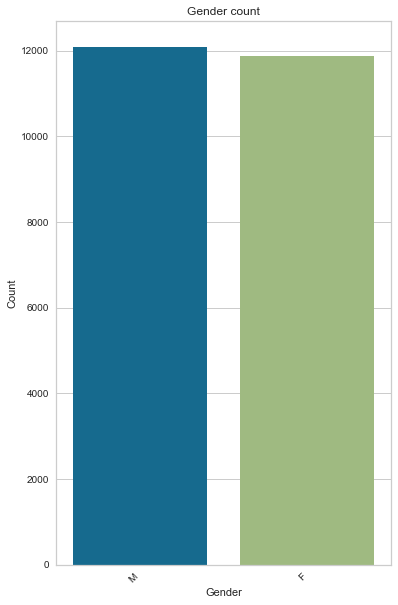

In [177]:
create_bar_plot(loan_amt_train_copy,'Gender')

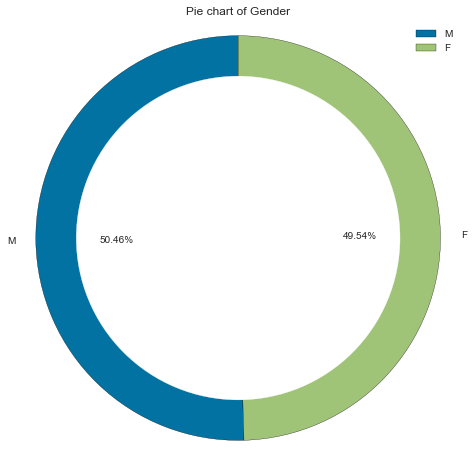

In [178]:
create_donnut_pie_chart(loan_amt_train_copy,'Gender')

Interpretation:
- We have almost the same number of Male vs Female (50.46% vs 49.54%)

### 2.3.2 Age

In [179]:
gen_info_feat(loan_amt_train_copy, 'Age')

Description:
count    24000.000000
mean        40.058417
std         16.029209
min         18.000000
25%         25.000000
50%         40.000000
75%         55.000000
max         65.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64


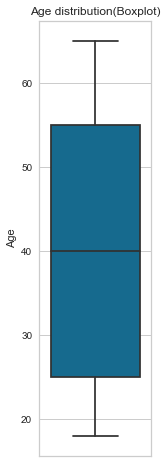

In [180]:
create_box_plot(loan_amt_train_copy, 'Age')

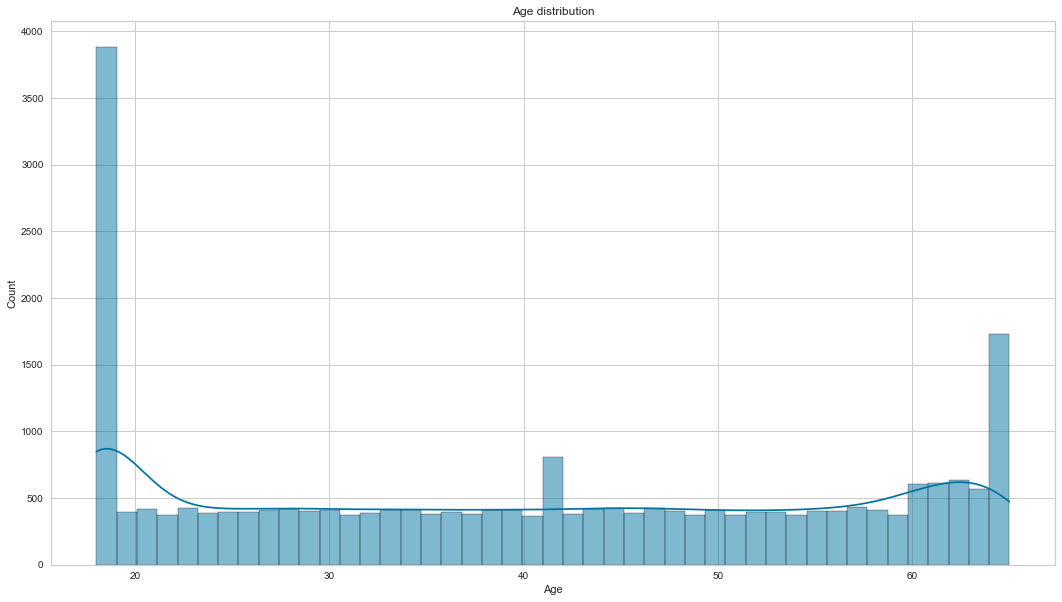

In [181]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

Interpretation:
- Age is not normally distributed
- We have a large number of applicants who are 18 and 65 years old
- Mean and median of age is 40 years old

# 2.3.3 Income

In [182]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count     20352.000000
mean       2567.533530
std        1775.075442
min         378.760000
25%        1652.707500
50%        2229.965000
75%        3092.775000
max      122966.280000
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64


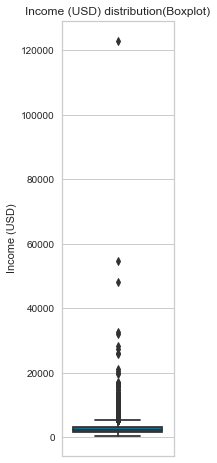

In [183]:
create_box_plot(loan_amt_train_copy, 'Income (USD)')

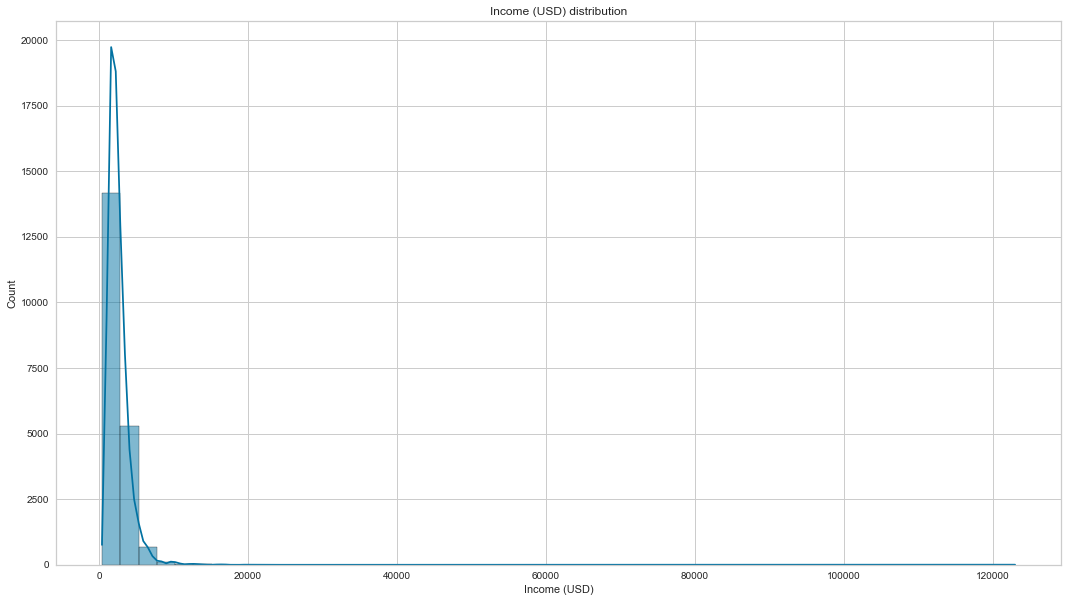

In [184]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [185]:
missing_val_norm(loan_amt_train_copy, 'Income (USD)')

'The percentage of missing rows is 15.20 %'

Interpretation:
- The Income feature has 15% of its data missing.
- The Income is positively skewed.
- The Income has a lot of outliers.
- The median income is $2229.

### 2.3.4 Income stability

In [186]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency (%)
Low   20617      90.919915
High   2059       9.080085


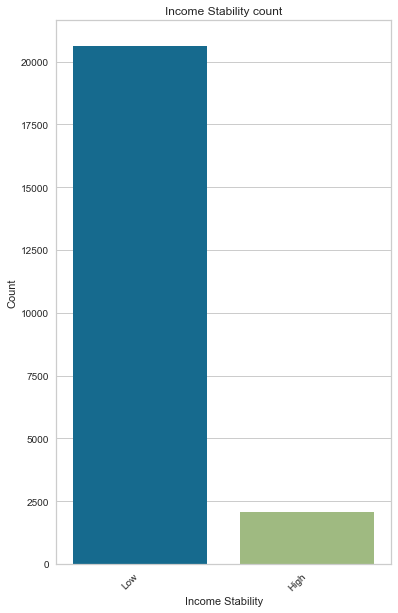

In [187]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

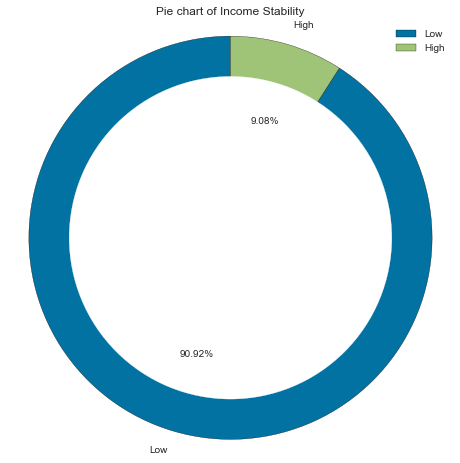

In [188]:
create_donnut_pie_chart(loan_amt_train_copy,'Income Stability')

Interpretation:
- Less than 10% of applicants have a high income stability
- 90% of applicants have a low income stability

## 2.3.5 Profession

In [189]:
gen_info_feat(loan_amt_train_copy,'Profession')

Description:
count       24000
unique          7
top       Working
freq        13509
Name: Profession, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               13509      56.287500
Commercial associate   6433      26.804167
Pensioner              2193       9.137500
State servant          1861       7.754167
Unemployed                2       0.008333
Businessman               1       0.004167
Student                   1       0.004167


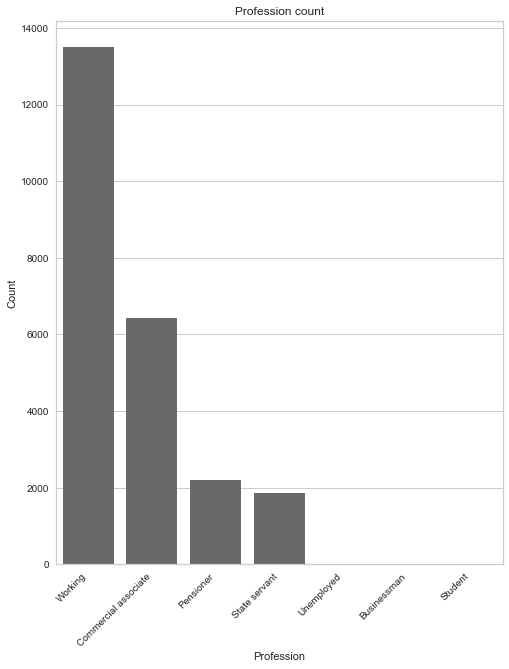

In [205]:
create_bar_plot(loan_amt_train_copy,'Profession')

Interpretation:
- Most applicants are currently working, the second most represented category is commercial associate.
- We also have a number of applicants that have pensioned and state servant.
- The most unrepresented category are the unemployed, businessman and student.

## 2.3.6 Type of employment

In [195]:
gen_info_feat(loan_amt_train_copy,'Type of Employment')

Description:
count        18228
unique          18
top       Laborers
freq          4495
Name: Type of Employment, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                4495      24.659864
Sales staff             2997      16.441738
Core staff              2605      14.291200
Managers                1996      10.950187
Drivers                 1273       6.983761
Accountants             1096       6.012728
High skill tech staff   1044       5.727452
Medicine staff           669       3.670178
Security staff           477       2.616853
Cooking staff            446       2.446785
Cleaning staff           283       1.552557
Private service staff    280       1.536098
Secretaries              132       0.724161
Low-skill Laborers       125       0.685758
Waiters/barmen staff     122       0.669300
Realty agents             73    

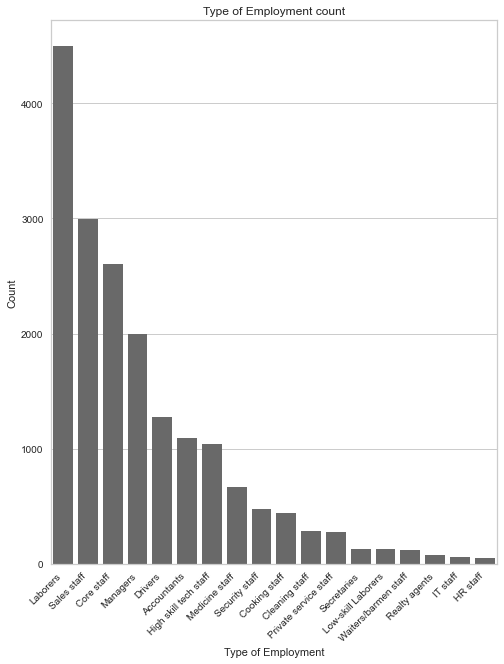

In [204]:
create_bar_plot(loan_amt_train_copy,'Type of Employment')

Interpretation:
- The most represented employment are laborers, sales staff, core staff and managers.
- The least represented employment are secretaries, low-skill laborers, waiters/barmen staff, realty agents, IT staff, HR staff.

## 2.3.7 Location

In [207]:
gen_info_feat(loan_amt_train_copy,'Location')

Description:
count          24000
unique             3
top       Semi-Urban
freq           17157
Name: Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban  17157        71.4875
Rural        4320        18.0000
Urban        2523        10.5125


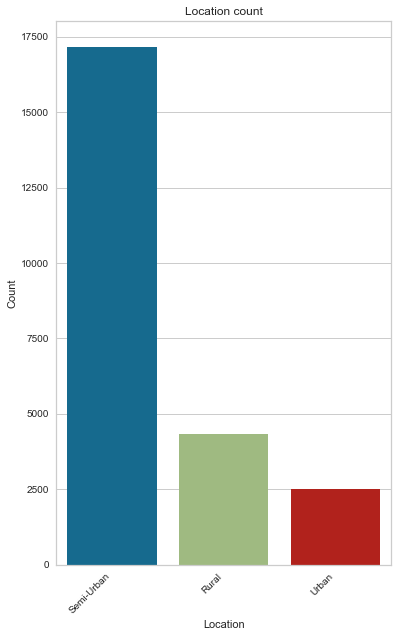

In [208]:
create_bar_plot(loan_amt_train_copy,'Location')

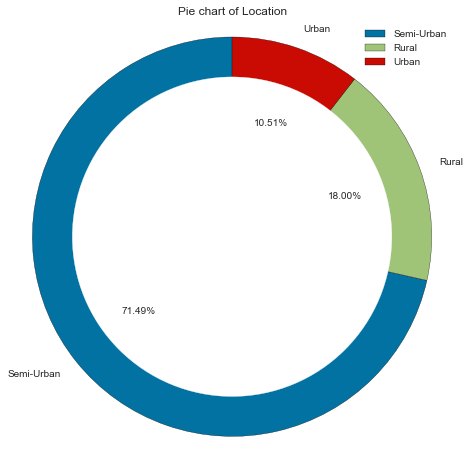

In [209]:
create_donnut_pie_chart(loan_amt_train_copy,'Location')

Interpretation:
- 7 out 10 applicants live in a semi-urban location
- Second most common location is the rural location
- Only 1 in 10 applicant live in an urban location

## 2.3.8 Loan Amount Request

In [213]:
gen_info_feat(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count     24000.000000
mean      89075.615086
std       59637.687461
min        6048.240000
25%       41272.637500
50%       75326.655000
75%      120378.247500
max      621497.820000
Name: Loan Amount Request (USD), dtype: float64
**************************************************
Object type:
float64


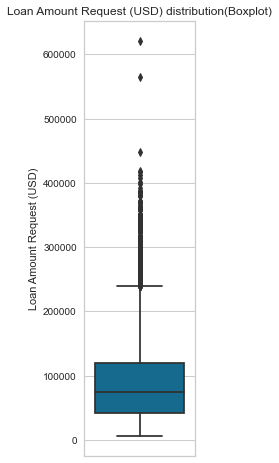

In [214]:
create_box_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

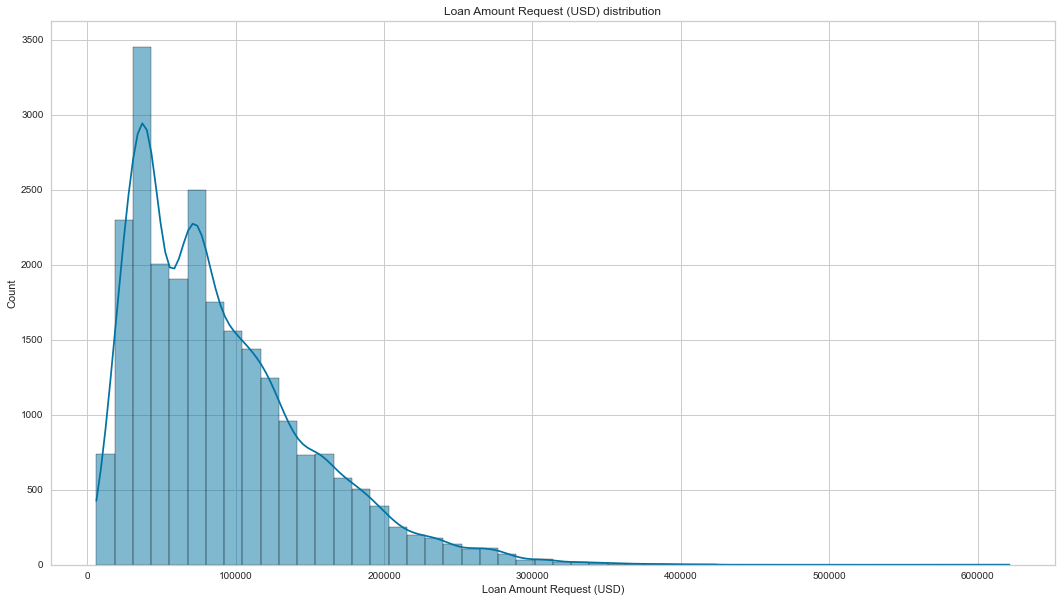

In [220]:
create_hist_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

Interpretation:
- The median of the loan amount request is $75326.655000
- We have quite a number of outliers in the loan amount request.
- The loan amount request distribution is positively skewed.

## 2.3.9 Current Loan Expenses

In [229]:
gen_info_feat(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count    23872.000000
mean       401.409325
std        241.893479
min       -999.000000
25%        248.932500
50%        375.275000
75%        521.215000
max       3419.660000
Name: Current Loan Expenses (USD), dtype: float64
**************************************************
Object type:
float64


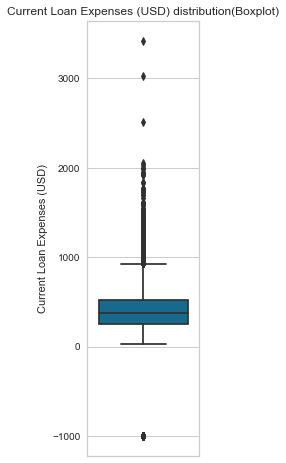

In [226]:
create_box_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

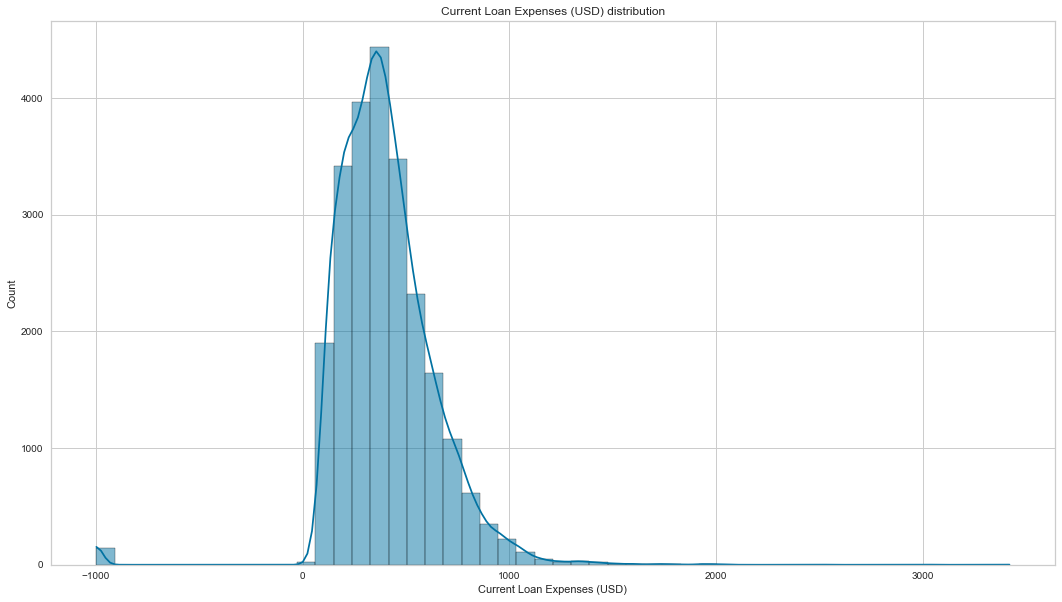

In [227]:
create_hist_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

Interpretation:
- The mean current loan expenses is $375.275
- We have also some outliers
- The current loan expenses is positively skewed

## 2.3.10 Expense Type 1

In [230]:
gen_info_feat(loan_amt_train_copy,'Expense Type 1')

Description:
count     24000
unique        2
top           N
freq      15361
Name: Expense Type 1, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  15361      64.004167
Y   8639      35.995833


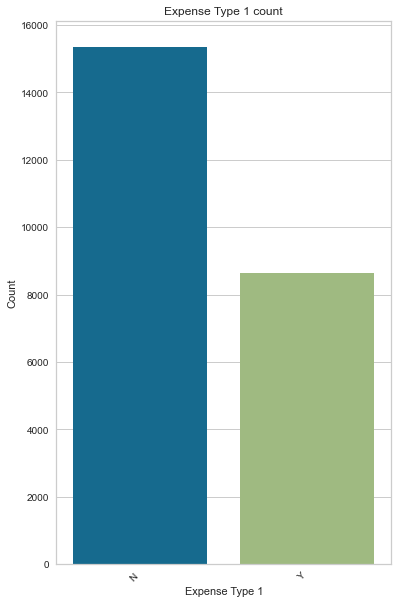

In [231]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

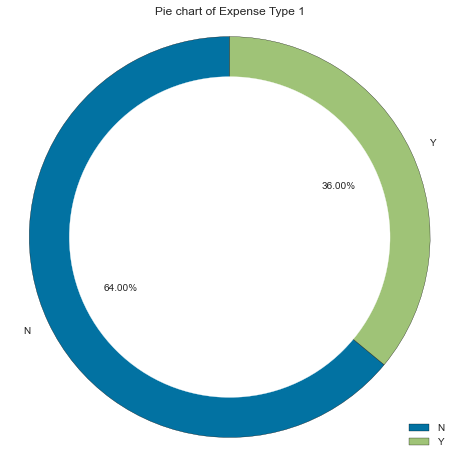

In [232]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 1')

Interpretation:
- More than half of applicants don't have the expenses type 1 on their loan.

## 2.3.11 Expense Type 2

In [233]:
gen_info_feat(loan_amt_train_copy,'Expense Type 2')

Description:
count     24000
unique        2
top           Y
freq      16116
Name: Expense Type 2, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  16116          67.15
N   7884          32.85


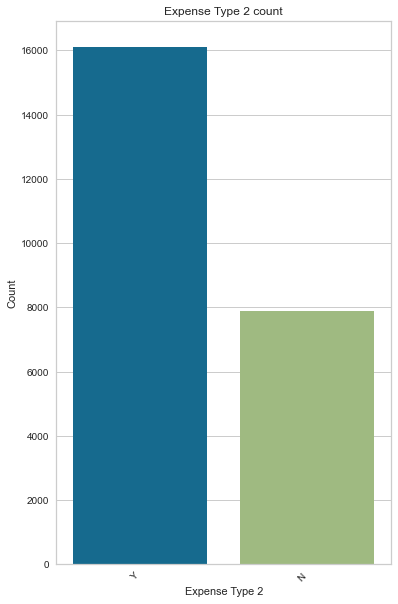

In [236]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

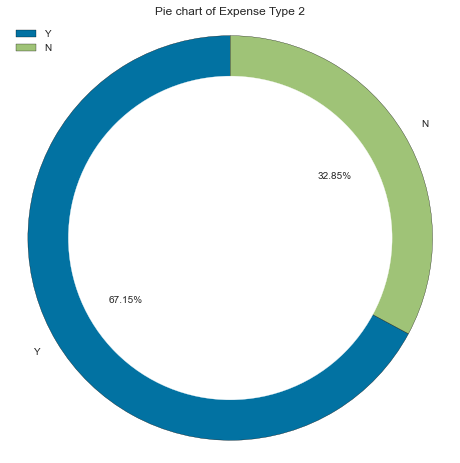

In [237]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 2')

Interpretation:
- The majority of applicants have expense type 2

## 2.3.12 Dependents

In [239]:
gen_info_feat(loan_amt_train_copy,'Dependents')

Description:
count    21983.000000
mean         2.250512
std          0.947379
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Dependents, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0   10471      47.632261
3.0    4568      20.779693
1.0    4447      20.229268
4.0    2160       9.825774
5.0     293       1.332848
6.0      37       0.168312
7.0       5       0.022745
8.0       1       0.004549
10.0      1       0.004549


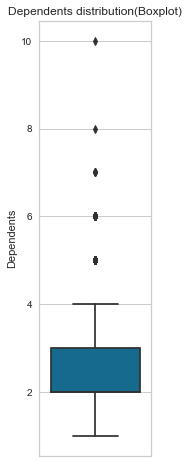

In [243]:
create_box_plot(loan_amt_train_copy, 'Dependents')

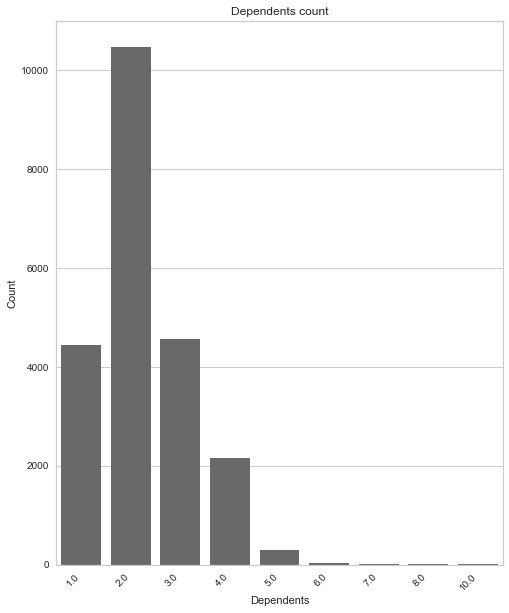

In [242]:
create_bar_plot(loan_amt_train_copy,'Dependents')

Interpretation:
- Most applicants have 2 dependents
- Then 1 and 3 dependents are the second most common
- Then 4 and 5 and so on

## 2.3.13 Credit Score

In [249]:
gen_info_feat(loan_amt_train_copy,'Credit Score')

Description:
count    22623.000000
mean       739.726632
std         72.271823
min        580.000000
25%        681.225000
50%        739.880000
75%        799.090000
max        896.260000
Name: Credit Score, dtype: float64
**************************************************
Object type:
float64


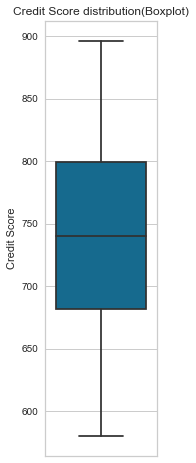

In [250]:
create_box_plot(loan_amt_train_copy, 'Credit Score')

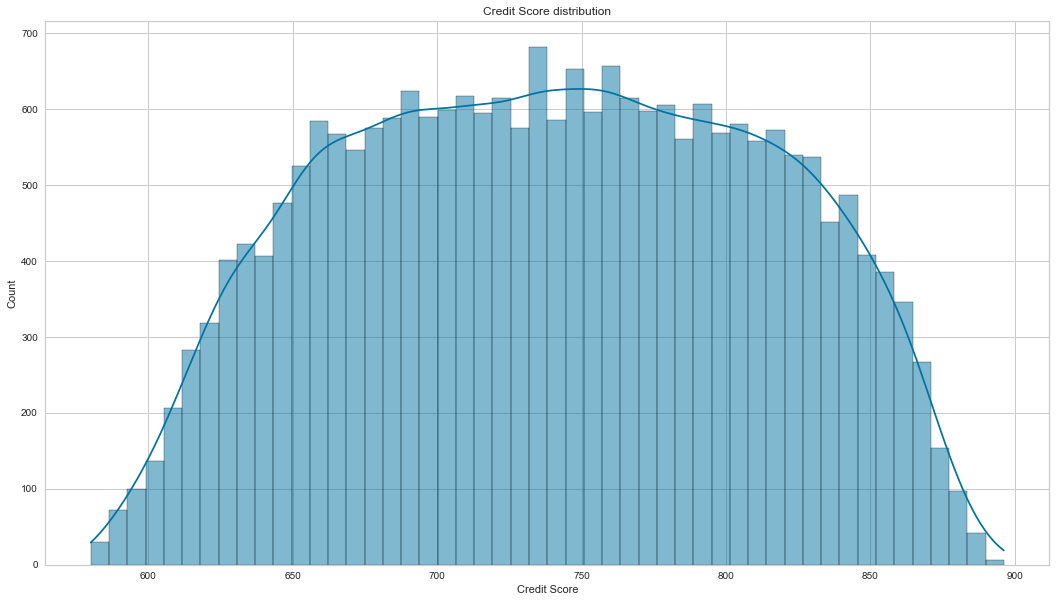

In [251]:
create_hist_plot(loan_amt_train_copy, 'Credit Score')

Interpretation:
- The mean and median of applicants's credit score is 739
- The credit score does not seems to be skewed but it is not normally distributed

## 2.3.14 Number of defaults

In [264]:
gen_info_feat(loan_amt_train_copy,'No. of Defaults')

Description:
count    24000.000000
mean         0.193875
std          0.395340
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: No. of Defaults, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  19347        80.6125
1   4653        19.3875


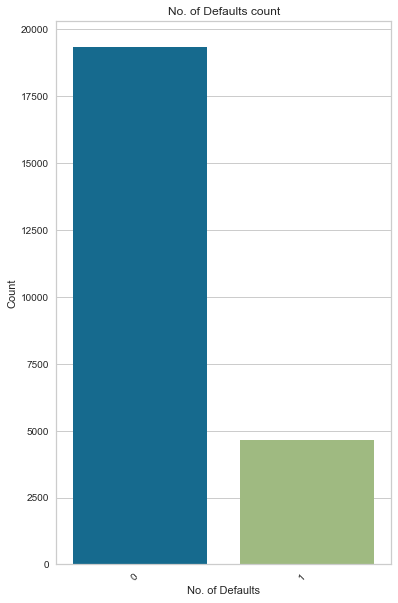

In [265]:
create_bar_plot(loan_amt_train_copy,'No. of Defaults')

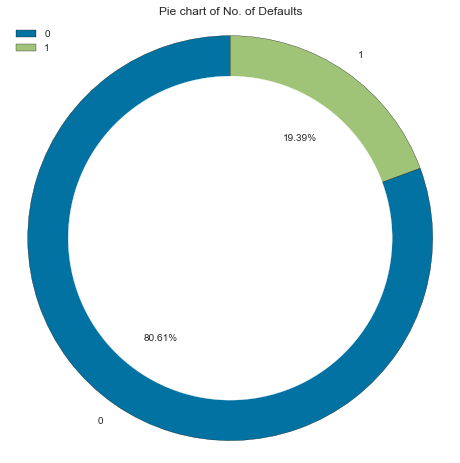

In [266]:
create_donnut_pie_chart(loan_amt_train_copy,'No. of Defaults')

Interpretation:
- 8 of 10 people don't have a any loan defaulted.

## 2.3.15 Has Active Credit Card

In [268]:
gen_info_feat(loan_amt_train_copy,'Has Active Credit Card')

Description:
count      22746
unique         3
top       Active
freq        7799
Name: Has Active Credit Card, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency (%)
Active        7799      34.287347
Inactive      7620      33.500396
Unpossessed   7327      32.212257


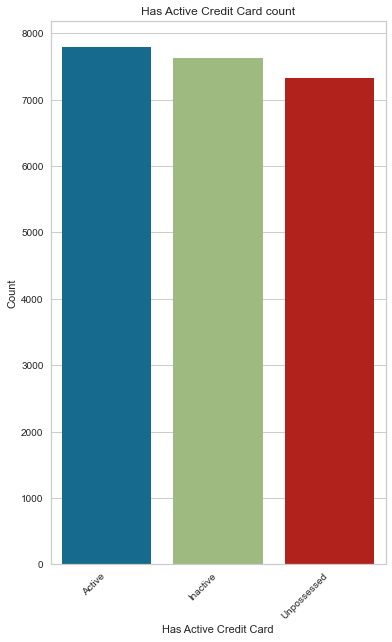

In [269]:
create_bar_plot(loan_amt_train_copy,'Has Active Credit Card')

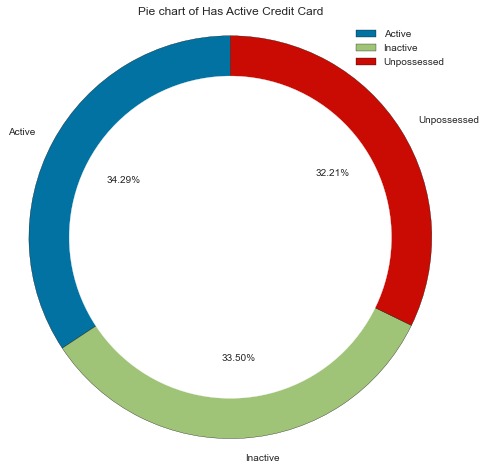

In [270]:
create_donnut_pie_chart(loan_amt_train_copy,'Has Active Credit Card')

Interpretation:
- We have almost an equal amount of people with an active, inactive and unpossessed credit card.

## 2.3.16 Property Age

In [274]:
gen_info_feat(loan_amt_train_copy,'Property Age')

Description:
count     20149.000000
mean       2567.841029
std        1776.812939
min         378.760000
25%        1653.040000
50%        2231.100000
75%        3094.050000
max      122966.280000
Name: Property Age, dtype: float64
**************************************************
Object type:
float64


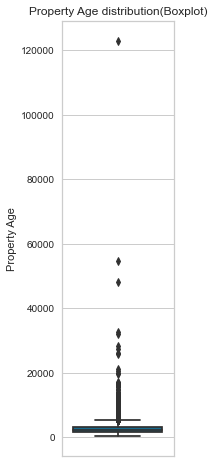

In [275]:
create_box_plot(loan_amt_train_copy, 'Property Age')

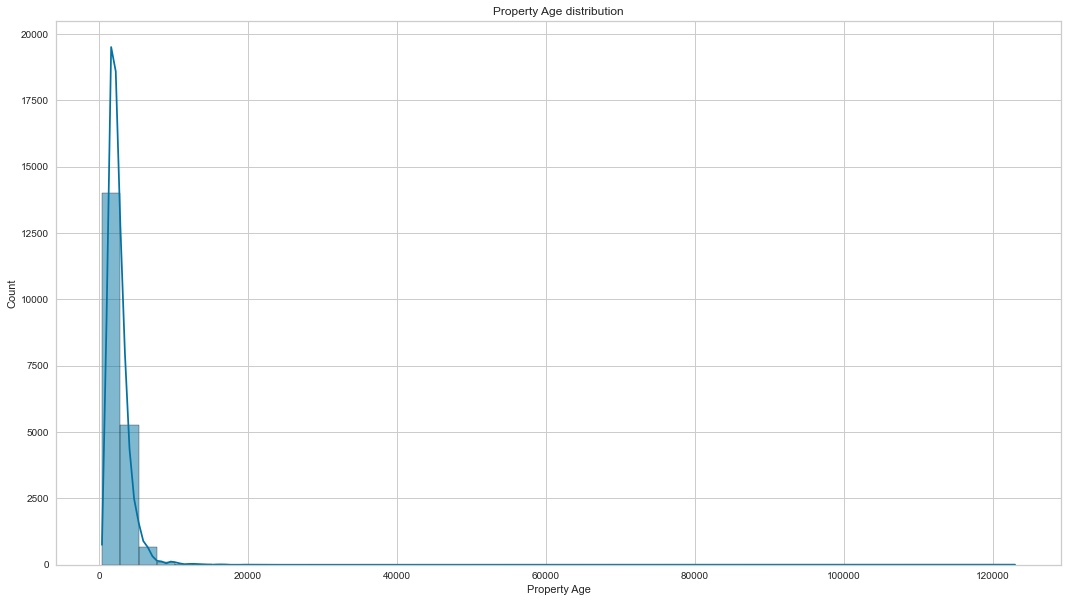

In [279]:
create_hist_plot(loan_amt_train_copy, 'Property Age')

Interpretation:
- Assuming that the property age is expressed in days, most of properties have a median age of 2231 days(6.1 years)
- The property age distribution is positively skewed


## 2.3.17 Property Type

In [281]:
gen_info_feat(loan_amt_train_copy,'Property Type')

Description:
count    24000.000000
mean         2.463708
std          1.121005
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Property Type, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1   6304      26.266667
2   6054      25.225000
3   5851      24.379167
4   5791      24.129167


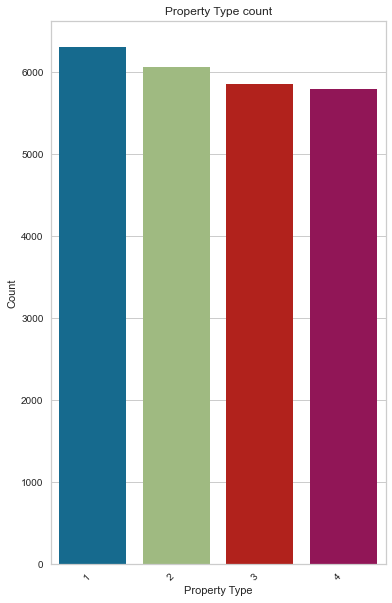

In [282]:
create_bar_plot(loan_amt_train_copy,'Property Type')

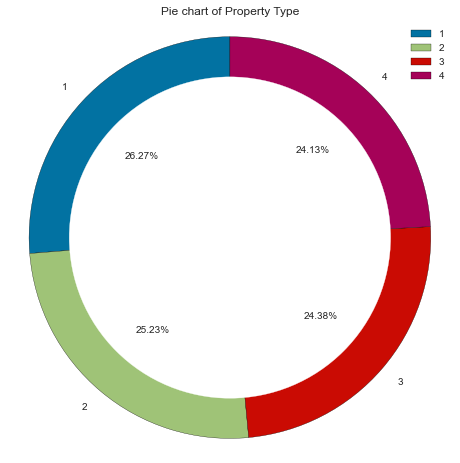

In [283]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Type')

Interpretation:
- We have almost an equal amount of property types, each with 25%

In [ ]:
## 2.3.18 